In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Hypothesis 1: More cars = worse air quality

Loading data

In [5]:
# Traffic data (November 2019)
path_traffic = '../arquivos/cordon-count-november-2019.csv'
traffic = pd.read_csv(path_traffic)

# Detailed air quality data (April 2022)
path_air = '../arquivos/AirView_DublinCity_Measurements_ugm3.csv'
air = pd.read_csv(path_air)

c:\Users\gisel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,5,6,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The air quality dataset contains high-resolution measurements (1 second intervals)
from April 2022. The traffic dataset is from November 2019.
Therefore, the datasets DO NOT overlap in time.
This analysis remains exploratory only. It does not support causal conclusions,
but can help investigate general spatial or trend relationships.

Cleaning and preparing traffic data

In [6]:
traffic['Date'] = pd.to_datetime(traffic['Date'], errors='coerce')
traffic = traffic.dropna(subset=['Date', 'CountValue'])
traffic['CountValue'] = pd.to_numeric(traffic['CountValue'], errors='coerce')

# Aggregate total traffic volume per day
traffic_daily = (
    traffic.groupby(['Date'])['CountValue']
    .sum()
    .reset_index()
    .rename(columns={'CountValue': 'TotalVehicles'})
)

Processing the air quality data

In [7]:
# Convert timestamp to datetime and extract date
air['gps_timestamp'] = pd.to_datetime(air['gps_timestamp'], errors='coerce')
air['date'] = air['gps_timestamp'].dt.date

# Select relevant columns and filter negative pollutant values
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
air_clean = air[['date'] + pollutants].copy()

# Remove invalid (negative) pollutant values
for col in pollutants:
    air_clean = air_clean[air_clean[col] >= 0]

# Aggregate average pollutants per day
air_daily = air_clean.groupby('date')[pollutants].mean().reset_index()
air_daily['date'] = pd.to_datetime(air_daily['date'])


Attempt to match by date (note: different years)
-----------------------------
We perform a merge only to illustrate potential correlation visually
but dates do not actually match — this is a methodological limitation.

Exploratory analysis

In [ ]:
# Weekly vehicle volume from SCATS dataset (Jan–Jun 2020)
import pandas as pd

# Load the SCATS dataset
traffic = pd.read_csv('../arquivos/scats_detector_volume_jan-jun-2020.csv')

# Build full date from Year, Month, Day
traffic['Date'] = pd.to_datetime(traffic[['Year', 'Month', 'Day']])

# Filter only the first 6 months (if needed)
traffic = traffic[(traffic['Date'] >= '2020-01-01') & (traffic['Date'] <= '2020-06-30')]

# Remove invalid counts
traffic = traffic.dropna(subset=['SumOfSumVolume'])
traffic['SumOfSumVolume'] = pd.to_numeric(traffic['SumOfSumVolume'], errors='coerce')

# Sum all volumes per day (across all sites)
traffic_daily = traffic.groupby('Date')['SumOfSumVolume'].sum().reset_index()
traffic_daily.rename(columns={'SumOfSumVolume': 'TotalVehicles'}, inplace=True)

# Add week number (ISO calendar) for grouping
traffic_daily['Week'] = traffic_daily['Date'].dt.isocalendar().week

# Aggregate weekly total (or mean) vehicle volume
traffic_weekly = (
    traffic_daily.groupby('Week')['TotalVehicles']
    .mean()  # or .sum() if you want total volume per week instead of average per day
    .reset_index()
)

# Preview weekly traffic
#traffic_weekly

In [34]:
# Load full air quality dataset
pollutants = ['NO_ugm3', 'NO2_ugm3', 'O3_ugm3', 'CO_mgm3', 'CO2_mgm3', 'PM25_ugm3']
cols = ['gps_timestamp'] + pollutants

air_2 = pd.read_csv(path_air, usecols=cols, parse_dates=['gps_timestamp'], low_memory=False)

# Filter for April to September 2022
#air_2 = air_2[(air_2['gps_timestamp'] >= '2022-04-01') & (air['gps_timestamp'] <= '2022-09-30')]

# Remove negative values
for col in pollutants:
   air_2 = air_2[air_2[col] >= 0]

# Create week number
air_2['Week'] = air_2['gps_timestamp'].dt.isocalendar().week

# Aggregate weekly averages for each pollutant
air_weekly = air_2.groupby('Week')[pollutants].mean().reset_index()


In [42]:
#air_2

In [41]:
#air_weekly

In [40]:
# Merge traffic and air quality weekly data
merged = pd.merge(traffic_weekly, air_weekly, on='Week')

# ⚠️ NOTE:
# These datasets refer to different years (2019 and 2022)
# and are only used for exploratory comparison of weekly patterns.
#merged

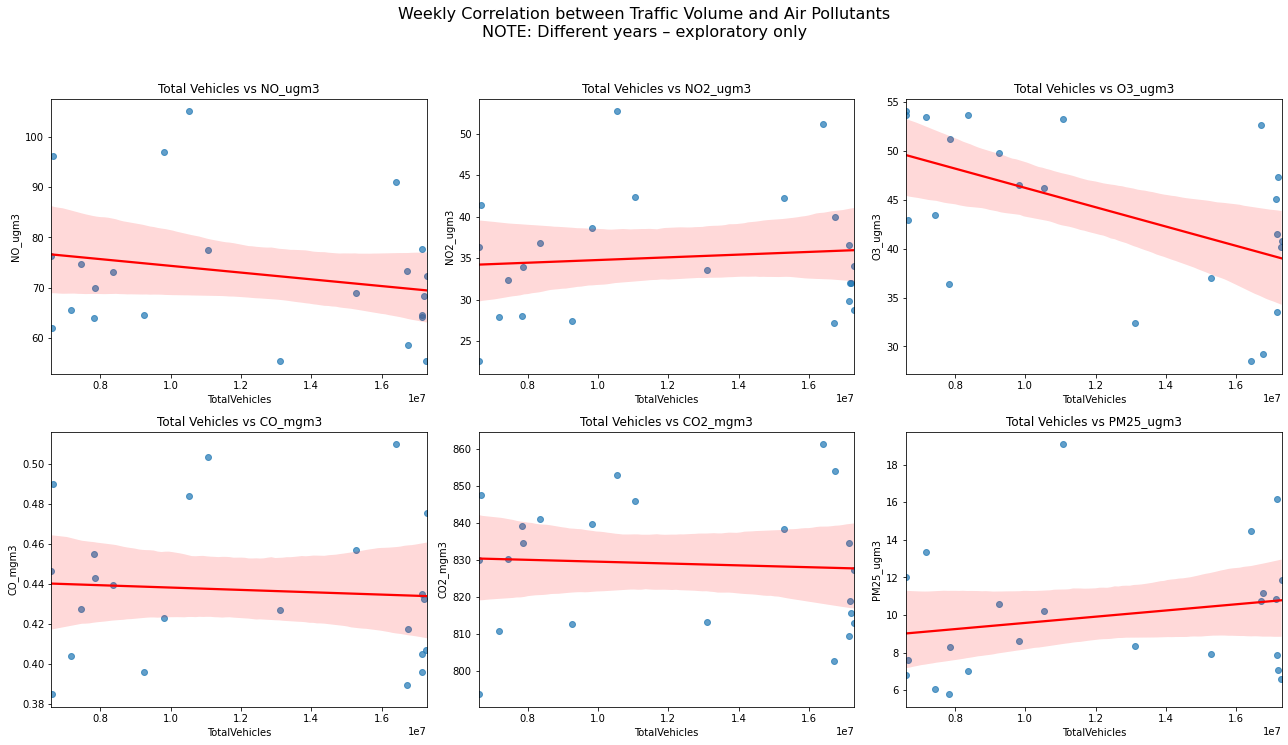

,Week,TotalVehicles,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3
Week,1.000000,-0.791746,0.393808,-0.001073,0.575229,0.124587,0.168725,-0.312144
TotalVehicles,-0.791746,1.000000,-0.223842,0.096064,-0.531529,-0.071249,-0.061468,0.214003
NO_ugm3,0.393808,-0.223842,1.000000,0.719246,0.075999,0.612571,0.606762,0.220861
NO2_ugm3,-0.001073,0.096064,0.719246,1.000000,-0.347839,0.796693,0.868288,0.356825
O3_ugm3,0.575229,-0.531529,0.075999,-0.347839,1.000000,-0.251977,-0.407518,-0.012591
CO_mgm3,0.124587,-0.071249,0.612571,0.796693,-0.251977,1.000000,0.797751,0.347098
CO2_mgm3,0.168725,-0.061468,0.606762,0.868288,-0.407518,0.797751,1.000000,0.253380
PM25_ugm3,-0.312144,0.214003,0.220861,0.356825,-0.012591,0.347098,0.253380,1.000000


In [38]:
# Plot correlation between traffic and each pollutant
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, pollutant in enumerate(pollutants):
    sns.regplot(
        ax=axes[i],
        data=merged,
        x='TotalVehicles',
        y=pollutant,
        scatter_kws={'alpha': 0.7},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'Total Vehicles vs {pollutant}')

plt.suptitle('Weekly Correlation between Traffic Volume and Air Pollutants\nNOTE: Different years – exploratory only', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

# Show correlation values
merged.corr()


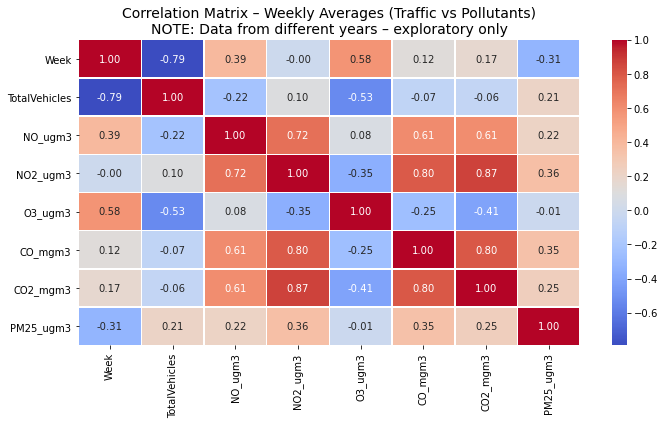

In [ ]:
# Correlation matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix – Weekly Averages (Traffic vs Pollutants)\nNOTE: Data from different years – exploratory only', fontsize=14)
plt.tight_layout()
plt.show()


📊 Interpretation of the Correlation Plots – Hypothesis 1: More Cars = Worse Air Quality
The plots display the weekly correlation between total vehicle volume and the average concentration of each air pollutant.

Each blue dot represents one week of data, combining traffic volumes (from January to June 2020) and air quality measurements (from April to September 2022). The red line indicates the linear trend, and the shaded area represents the confidence interval.

#### 🔍 Pollutant-by-pollutant interpretation:
- NO (Nitric Oxide):
The trend is slightly negative, suggesting that higher traffic volumes are not consistently associated with increased NO levels. This goes against expectations and may reflect data noise or meteorological influences.

- NO₂ (Nitrogen Dioxide):
The trend is almost flat, with a very weak positive slope. NO₂ is typically a key indicator of vehicle emissions, but no strong correlation is observed here.

- O₃ (Ozone):
The plot shows a negative trend. This is expected, as NO reacts with O₃ and tends to reduce its concentration in areas with heavy traffic. This relationship is consistent with real-world chemical behavior.

- CO (Carbon Monoxide):
The trend is nearly flat, indicating no significant correlation with vehicle volume. Weekly CO variations appear to be minor or influenced by other sources.

- CO₂ (Carbon Dioxide):
A very slight negative trend is observed, but with minimal variation. CO₂ is a background gas affected by multiple factors and may not reflect short-term traffic changes.

- PM2.5 (Fine Particulate Matter):
A slightly positive trend appears, which could suggest that traffic contributes to particle emissions. However, the correlation remains weak due to wide dispersion across weeks.



#### 📌 Conclusion:
While some pollutants (such as O₃ and PM2.5) show trends that align with the initial hypothesis (i.e., more cars lead to worse air quality), most relationships are weak or inconsistent.
This may be explained by:

The difference in the year of data collection (2020 for traffic vs. 2022 for air quality);

Meteorological variability and wind dispersion;

The influence of other pollution sources;

Sensor limitations or measurement noise.

These results highlight the importance of using temporally aligned datasets and controlling for external factors when testing environmental hypotheses.

